In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../cf-train.csv',index_col=0) # 这里用的还是obj的grade
test = pd.read_csv('../cf-testa.csv',index_col=0)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  int64  
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  float64
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [12]:
train['grade'] = train['grade'].astype('category')

In [9]:
train['subGrade']= train['subGrade'].astype('category')
test['grade'] = test['grade'].astype('category')
test['subGrade']= test['subGrade'].astype('category')

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  200000 non-null  int64   
 1   loanAmnt            200000 non-null  int64   
 2   term                200000 non-null  int64   
 3   interestRate        200000 non-null  float64 
 4   installment         200000 non-null  float64 
 5   grade               200000 non-null  category
 6   subGrade            200000 non-null  category
 7   employmentTitle     200000 non-null  int64   
 8   employmentLength    188258 non-null  float64 
 9   homeOwnership       200000 non-null  int64   
 10  annualIncome        200000 non-null  float64 
 11  verificationStatus  200000 non-null  int64   
 12  issueDate           200000 non-null  object  
 13  purpose             200000 non-null  int64   
 14  postCode            200000 non-null  int64   
 15  regionCode       

<AxesSubplot:>

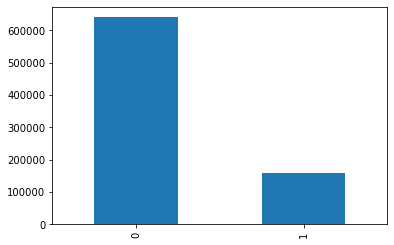

In [3]:
train['isDefault'].value_counts().sort_index().plot(kind = 'bar')

### Santander Train & Test分布

### 结果让人迷惑

In [18]:
train['label'] = 0
test['label']  = 1
trte = pd.concat([train,test],axis=0,ignore_index=True)

import lightgbm as lgb
import time
from sklearn.model_selection import KFold,StratifiedKFold

def validation_prediction_lgb(X,y,feature_names, ratio =1, X_test = None,istest = False):
    n_fold = 5
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    params = {
    'bagging_freq': 5, 
    'boost_from_average':'false',
    'boost': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 5,
    'metric':'auc',
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 10.0,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1}

    importances = pd.DataFrame() 

    if istest:
        prediction = np.zeros(len(X_test))
    models = []

    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        weights = [ratio  if val == 1 else 1 for val in y_train]
        train_data = lgb.Dataset(X_train, label=y_train,  weight=weights)
        valid_data = lgb.Dataset(X_valid, label=y_valid)
        model = lgb.train(params,train_data,num_boost_round=20000,
                        valid_sets = [train_data, valid_data],verbose_eval=200,early_stopping_rounds = 200)

        imp_df = pd.DataFrame() 
        imp_df['feature']  = feature_names
        imp_df['split']    = model.feature_importance()
        imp_df['gain']     = model.feature_importance(importance_type='gain')
        imp_df['fold']     = fold_n + 1
        importances = pd.concat([importances, imp_df], axis=0)
        models.append(model)

        if istest == True:
            prediction += model.predict(X_test, num_iteration=model.best_iteration)/5
    if istest == True:     
        return models,importances, prediction
    else:
        return models,importances
    
train_cols = [col for col in trte.columns if col not in ['target','ID_code',\
                            'label','grade','subGrade','issueDate','earliesCreditLine']]
print(len(train_cols))

models,importances = validation_prediction_lgb(trte[train_cols].values, trte['label'].values, train_cols)

42
Fold 0 started at Thu Sep 17 17:37:01 2020
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold 1 started at Thu Sep 17 17:37:07 2020
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold 2 started at Thu Sep 17 17:37:12 2020
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold 3 started at Thu Sep 17 17:37:17 2020
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
Fold 4 started at Thu Sep 17 17:37:22 2020
Training until validation scores don't improve for 200 rounds
[200]	traini

In [3]:
print('Train data shape:',train.shape)
print('TestA data shape:',test.shape)

Train data shape: (800000, 46)
TestA data shape: (200000, 45)


In [4]:
pd.set_option('display.max_columns', None)
train.head(10)

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,n0,n1,n2,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT
0,0,35000,5,19.52,918.00,E,E2,320.0,64.0,2,110000.0,2,2014-07-01,1,1,137.0,32,17.05,0,730,734,7,0,0.0,24178,48.9,27,0,0,2001-08-01,1.0,0.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2588.0
1,1,18000,5,18.48,462.00,D,D2,219843.0,-61.0,0,46000.0,2,2012-08-01,0,0,156.0,18,27.83,0,700,704,13,0,0.0,15096,38.9,18,1,0,2002-05-01,1723.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,1888.0
2,2,12000,5,16.98,298.20,D,D3,31698.0,-46.0,0,74000.0,2,2015-10-01,0,0,337.0,14,22.77,0,675,679,11,0,0.0,4606,51.8,27,0,0,2006-05-01,0.0,0.0,0.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,3044.0
3,3,11000,3,7.26,341.00,A,A4,46854.0,6.0,1,118000.0,1,2015-08-01,0,4,148.0,11,17.20,0,685,689,9,0,0.0,9948,52.6,28,1,0,1999-05-01,4.0,6.0,4.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2984.0
4,4,3000,3,12.99,101.06,C,C2,54.0,54.0,1,29000.0,2,2016-03-01,0,10,301.0,21,32.16,0,690,694,12,0,0.0,2942,32.0,27,0,0,1977-08-01,11.0,1.0,2.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,3196.0
5,5,11000,3,7.99,344.80,A,A5,51727.0,15.0,0,39000.0,2,2017-04-01,0,9,512.0,21,17.14,0,730,734,19,0,0.0,4047,31.1,52,1,0,1998-07-01,10.0,12.0,1.0,2.0,1.0,1.0,48.0,2.0,3.0,2.0,19.0,0.0,0.0,0.0,0.0,3592.0
6,6,2050,3,7.69,63.94,A,A4,180083.0,115.0,0,35000.0,0,2014-10-01,0,0,517.0,14,17.48,0,755,759,12,0,0.0,3111,8.5,23,0,0,2006-10-01,0.0,0.0,1.0,3.0,7.0,11.0,3.0,10.0,18.0,3.0,12.0,0.0,0.0,0.0,3.0,2680.0
7,7,11500,3,14.98,398.50,C,C3,214017.0,1.0,1,30000.0,2,2014-01-01,0,0,100.0,4,32.60,0,665,669,8,1,1.0,14021,59.7,33,1,0,1994-12-01,0.0,0.0,4.0,4.0,4.0,16.0,10.0,5.0,21.0,4.0,8.0,0.0,0.0,0.0,2.0,2406.0
8,8,12000,3,12.99,404.20,C,C2,188.0,-68.0,2,60000.0,1,2016-05-01,1,0,792.0,13,19.22,0,690,694,15,0,0.0,27176,46.0,21,1,0,1994-04-01,0.0,0.0,7.0,13.0,7.0,7.0,2.0,13.0,17.0,11.0,15.0,NaN,0.0,0.0,6.0,3256.0
9,9,6500,3,10.99,212.80,B,B4,54.0,54.0,1,15300.0,2,2015-11-01,0,0,59.0,11,24.39,0,725,729,7,0,0.0,2936,30.6,63,0,0,1993-01-01,0.0,0.0,4.0,5.0,4.0,21.0,24.0,6.0,39.0,5.0,7.0,0.0,0.0,0.0,8.0,3076.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 0 to 799999
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  int64  
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    799999 non-null  float64
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

### grade & subgrade

In [6]:
train['subGrade'].value_counts().sort_index()

A1    25909
A2    22124
A3    22655
A4    30928
A5    38045
B1    42382
B2    44227
B3    48600
B4    49516
B5    48965
C1    50763
C2    47068
C3    44751
C4    44272
C5    40264
D1    30538
D2    26528
D3    23410
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64

### 就是每一组，不还的占比

In [7]:
train['subGrade'].value_counts().sort_values(ascending=False)

C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64

In [8]:
train['employmentTitle'].value_counts().sort_values(ascending=False)

54.0        51149
38.0        12644
32.0        11543
184.0        6112
151.0        5193
            ...  
42012.0         1
41984.0         1
52857.0         1
119041.0        1
52118.0         1
Name: employmentTitle, Length: 248683, dtype: int64

In [9]:
test['employmentTitle'].value_counts().sort_values(ascending=False)

54        12829
38         3234
32         2979
184        1527
151        1340
          ...  
358868        1
84434         1
88528         1
371150        1
56079         1
Name: employmentTitle, Length: 79282, dtype: int64

In [10]:
train['purpose'].value_counts().sort_values(ascending=False)

0     464096
4     175433
2      52129
5      46276
3      17579
9       9238
1       9106
8       8657
10      5652
7       5373
6       4354
12      1363
11       554
13       190
Name: purpose, dtype: int64

In [11]:
test['purpose'].value_counts().sort_values(ascending=False)

0     116130
4      43898
2      12936
5      11504
3       4442
9       2322
1       2263
8       2155
10      1396
7       1357
6       1062
12       339
11       138
13        58
Name: purpose, dtype: int64

In [12]:
train['regionCode'].value_counts().sort_values(ascending=False)

8     116921
14     65768
13     65041
21     56671
2      30513
30     28634
0      27180
19     26198
3      25766
9      22902
7      22600
23     20919
10     19604
12     18543
26     18432
22     17722
18     17286
4      14177
11     12929
24     12776
32     12065
38     11982
36     11644
27     10521
17      9863
35      9669
5       9581
20      9124
43      7701
42      7267
15      6690
37      5998
45      5932
16      4325
28      4036
44      3963
33      3817
6       3496
39      2943
40      2287
31      2261
34      2136
25      2102
48      1880
41      1778
1       1624
29      1560
47      1213
49      1001
46       953
50         6
Name: regionCode, dtype: int64

In [13]:
test['regionCode'].value_counts().sort_values(ascending=False)

8     29031
13    16309
14    16249
21    14492
2      7666
30     7299
0      6821
19     6429
3      6358
7      5633
9      5607
23     5327
10     4747
26     4654
12     4577
22     4394
18     4286
4      3600
11     3348
24     3086
38     3042
32     3026
36     2928
27     2628
35     2491
17     2471
5      2349
20     2330
43     1880
42     1826
15     1641
45     1583
37     1472
16     1170
28     1000
44      969
33      949
6       909
39      712
31      581
40      579
34      527
48      499
25      493
1       441
41      406
29      384
47      304
49      274
46      222
50        1
Name: regionCode, dtype: int64

In [14]:
train['postCode'].value_counts().sort_values(ascending=False)

134.0    8956
19.0     8611
51.0     8161
31.0     7337
4.0      7176
         ... 
877.0       1
856.0       1
907.0       1
884.0       1
916.0       1
Name: postCode, Length: 932, dtype: int64

In [15]:
test['postCode'].value_counts().sort_values(ascending=False)

134    2136
19     2105
51     2028
31     1851
4      1790
       ... 
886       1
821       1
896       1
887       1
858       1
Name: postCode, Length: 889, dtype: int64

In [19]:
import pandas_profiling
pfr = pandas_profiling.ProfileReport(train)
pfr.to_file("./traineg.html")

In [17]:
pfr = pandas_profiling.ProfileReport(test)
pfr.to_file("./testeg.html")

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 45 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  200000 non-null  int64  
 1   loanAmnt            200000 non-null  int64  
 2   term                200000 non-null  int64  
 3   interestRate        200000 non-null  float64
 4   installment         200000 non-null  float64
 5   grade               200000 non-null  object 
 6   subGrade            200000 non-null  object 
 7   employmentTitle     200000 non-null  int64  
 8   employmentLength    200000 non-null  int64  
 9   homeOwnership       200000 non-null  int64  
 10  annualIncome        200000 non-null  float64
 11  verificationStatus  200000 non-null  int64  
 12  issueDate           200000 non-null  object 
 13  purpose             200000 non-null  int64  
 14  postCode            200000 non-null  int64  
 15  regionCode          200000 non-nul